# ML Analysis: Cross-selling effects

* Problem statement
  * The product category furniture does not produce many profits, even losses. Therefore, the questions arises if it is still useful to keep this product in the portfolio.
  * Generally, furniture has higher operational costs for logistics (storage, transportation).
  * Thus, the company could make a shift in the product portfolio.
* Approach
  * Analyse the cross-selling effects in the product portfolio using clustering.
  * Product-Level Clustering (Product Affinity/Market Basket Analysis)
    * uncover co-purchase patterns
    * co-occurrence matrix
  * Customer Segmentation based on Purchase Behavior
* Assumption:
  * It is still useful to keep the products in the portfolio, because what is a office stuff shop without furniture? It is going to entice customers. We need to quantify this anyhow and preferebly see that over time.
  * The product segment is growing.
* Further questions: 
  * How can profits be maximized?

In [54]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd
import yaml

In [55]:
import gower
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import RobustScaler, StandardScaler

In [56]:
with open('../config.yaml') as file:
    config = yaml.safe_load(file)

# Getting dem data

Features

* RFM Metrics (for overall customer value):
  * Recency: Days since last purchase (overall).
  * Frequency: Total number of purchases/orders.
  * Monetary: Total spend across all categories (total_spend_overall).
* Category-Specific Metrics:
  * Total_Spend_Category_X (e.g., Total_Spend_LowProfitCategory)
  * Number_of_Purchases_Category_X (frequency in that category)
  * Has_Purchased_Category_X (binary flag: 0 or 1)
  * Average_Order_Value_Category_X (if applicable)
* Breadth of Purchase:
  * Number_of_Unique_Product_Categories_Purchased
  * Number_of_Unique_Products_Purchased

In [57]:
db_path = Path(config['processed_data']['database_sqlite'])
query_path = Path(config['queries_path'])

with sqlite3.connect(db_path) as conn:
    
    with open(query_path.joinpath('create_views.sql'), 'r') as f:
        conn.executescript(f.read())

    with open(query_path.joinpath('select_data_for_product_segmentation.sql'), 'r') as f:
        # cur = conn.executescript(f.read())
        df = pd.read_sql_query(f.read(), conn)

In [58]:
df = df.set_index('CustomerID')        
df.head()

,Segment,NumOrders,Sales,AOV,Profit,Recency,SalesTechnology,SalesOfficeSupplies,SalesFurniture,NumOrdersTechnology,...,SalesFurnitureProfitable,ProfitFurniture,HasBoughtFurniture,HasBoughtFurnitureNotProfitable,HasBoughtFurnitureProfitable,FracSalesTechnology,FracSalesOfficeSupplies,FracSalesFurniture,FracSalesFurnitureNotProfitable,FracSalesFurnitureProfitable
CustomerID,,,,,,,,,,,,,,,,,,,,,
AA-10315,Consumer,5,5563.560,1112.712000,-362.8825,184.0,473.696,5075.304,14.560,2,...,14.560,6.2608,1,0,1,0.085143,0.912240,0.002617,0.000000,0.002617
AA-10375,Consumer,9,1056.390,117.376667,277.3824,19.0,766.930,261.060,28.400,3,...,28.400,11.0760,1,0,1,0.725991,0.247125,0.026884,0.000000,0.026884
AA-10480,Consumer,4,1790.512,447.628000,435.8274,259.0,689.940,625.272,475.300,2,...,27.460,108.4104,1,1,1,0.385331,0.349214,0.265455,0.250118,0.015336
AA-10645,Consumer,6,5086.935,847.822500,857.8033,55.0,354.682,981.540,3750.713,2,...,1402.825,648.8834,1,1,1,0.069724,0.192953,0.737323,0.461553,0.275770
AB-10015,Consumer,3,886.156,295.385333,129.3465,415.0,221.980,273.504,390.672,1,...,341.960,60.1937,1,1,1,0.250498,0.308641,0.440861,0.054970,0.385891


## Set data types

In [90]:
# TODO how to set datatypes in sql view or sql import
df.dtypes

Segment                             object
NumOrders                            int64
Sales                              float64
AOV                                float64
Profit                             float64
Recency                            float64
SalesTechnology                    float64
SalesOfficeSupplies                float64
SalesFurniture                     float64
NumOrdersTechnology                  int64
NumOrdersOfficeSupplies              int64
NumOrdersFurniture                   int64
SalesFurnitureChair                float64
SalesFurnitureTables               float64
SalesFurnitureFurnishings          float64
SalesFurnitureBookcases            float64
SalesFurnitureNotProfitable        float64
SalesFurnitureProfitable           float64
ProfitFurniture                    float64
HasBoughtFurniture                   int64
HasBoughtFurnitureNotProfitable      int64
HasBoughtFurnitureProfitable         int64
FracSalesTechnology                float64
FracSalesOf

In [91]:
# df.Segment = df.Segment.astype('category')        # does not work with gower
# df.Segment = df.Segment.astype(pd.StringDtype())  # does not work with gower
df.Segment = df.Segment.astype('str')

# Data Scanning

## Skew

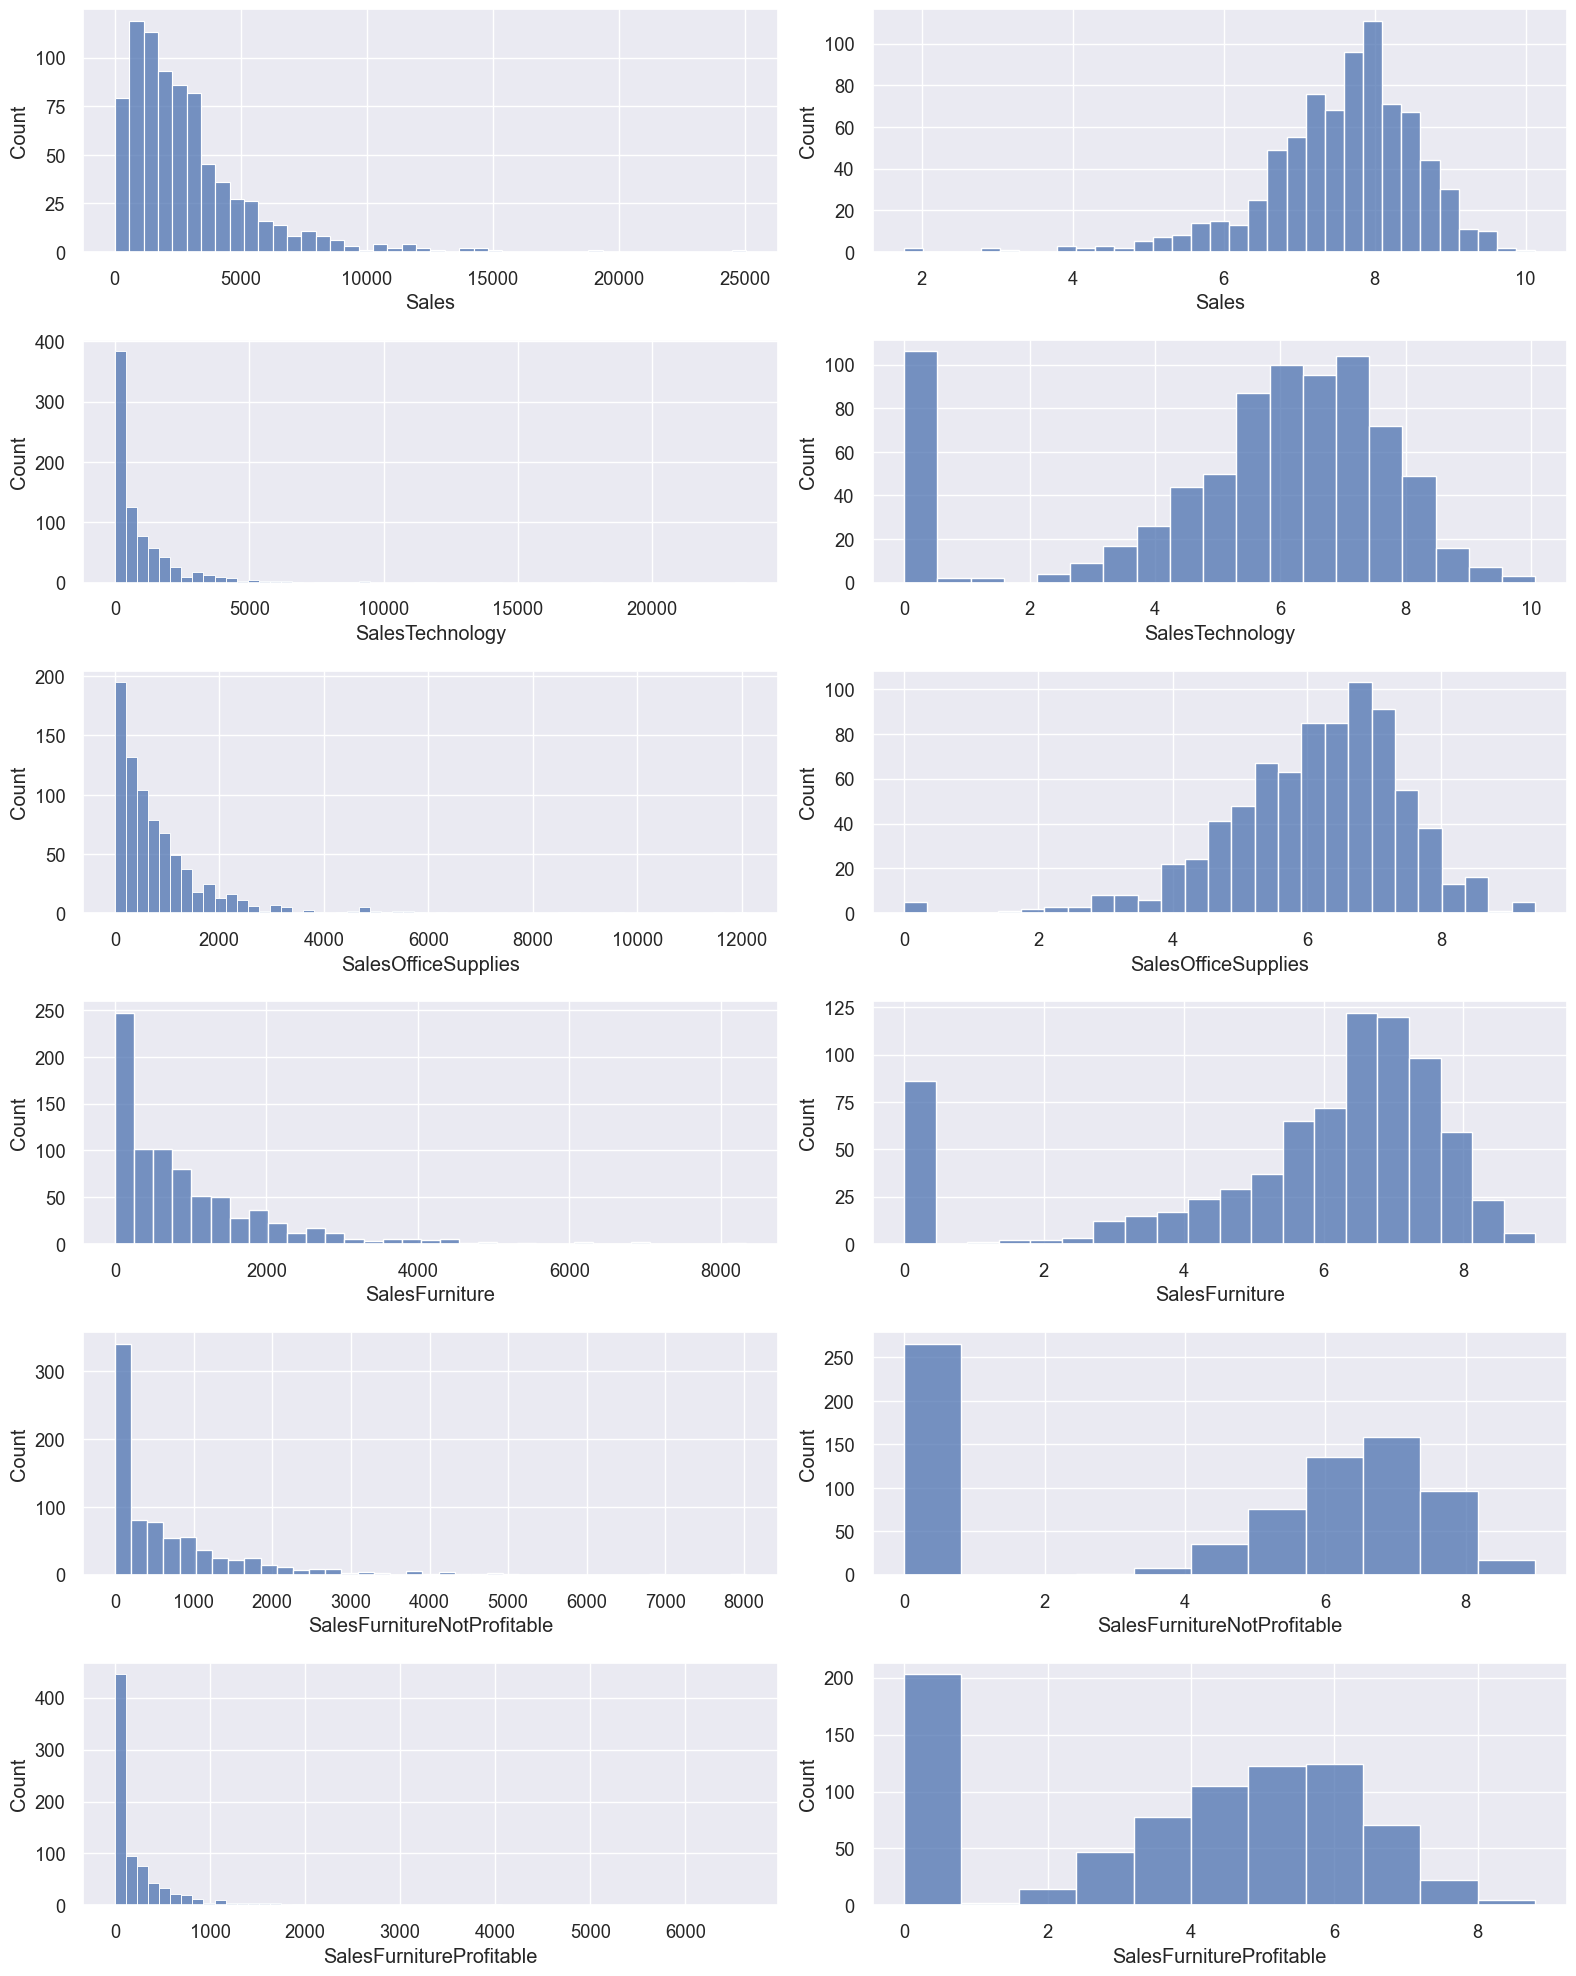

In [ ]:
# check skew
fig, axs = plt.subplots(len(numeric_features), 2, figsize=(16, 20))

for feat, ax in zip(numeric_features, axs[:,0]):
    sns.histplot(df[feat], ax=ax)

for feat, ax in zip(numeric_features, axs[:,1]):
    sns.histplot(np.log1p(df[feat]), ax=ax)

plt.tight_layout()

* Dem data is damn skewed: apply a log1p transformation to get dem data more nice.
* There are some outliers that might not be relevant for this analysis, since we want to see the usual customers behaviour.

## Feature Correlations

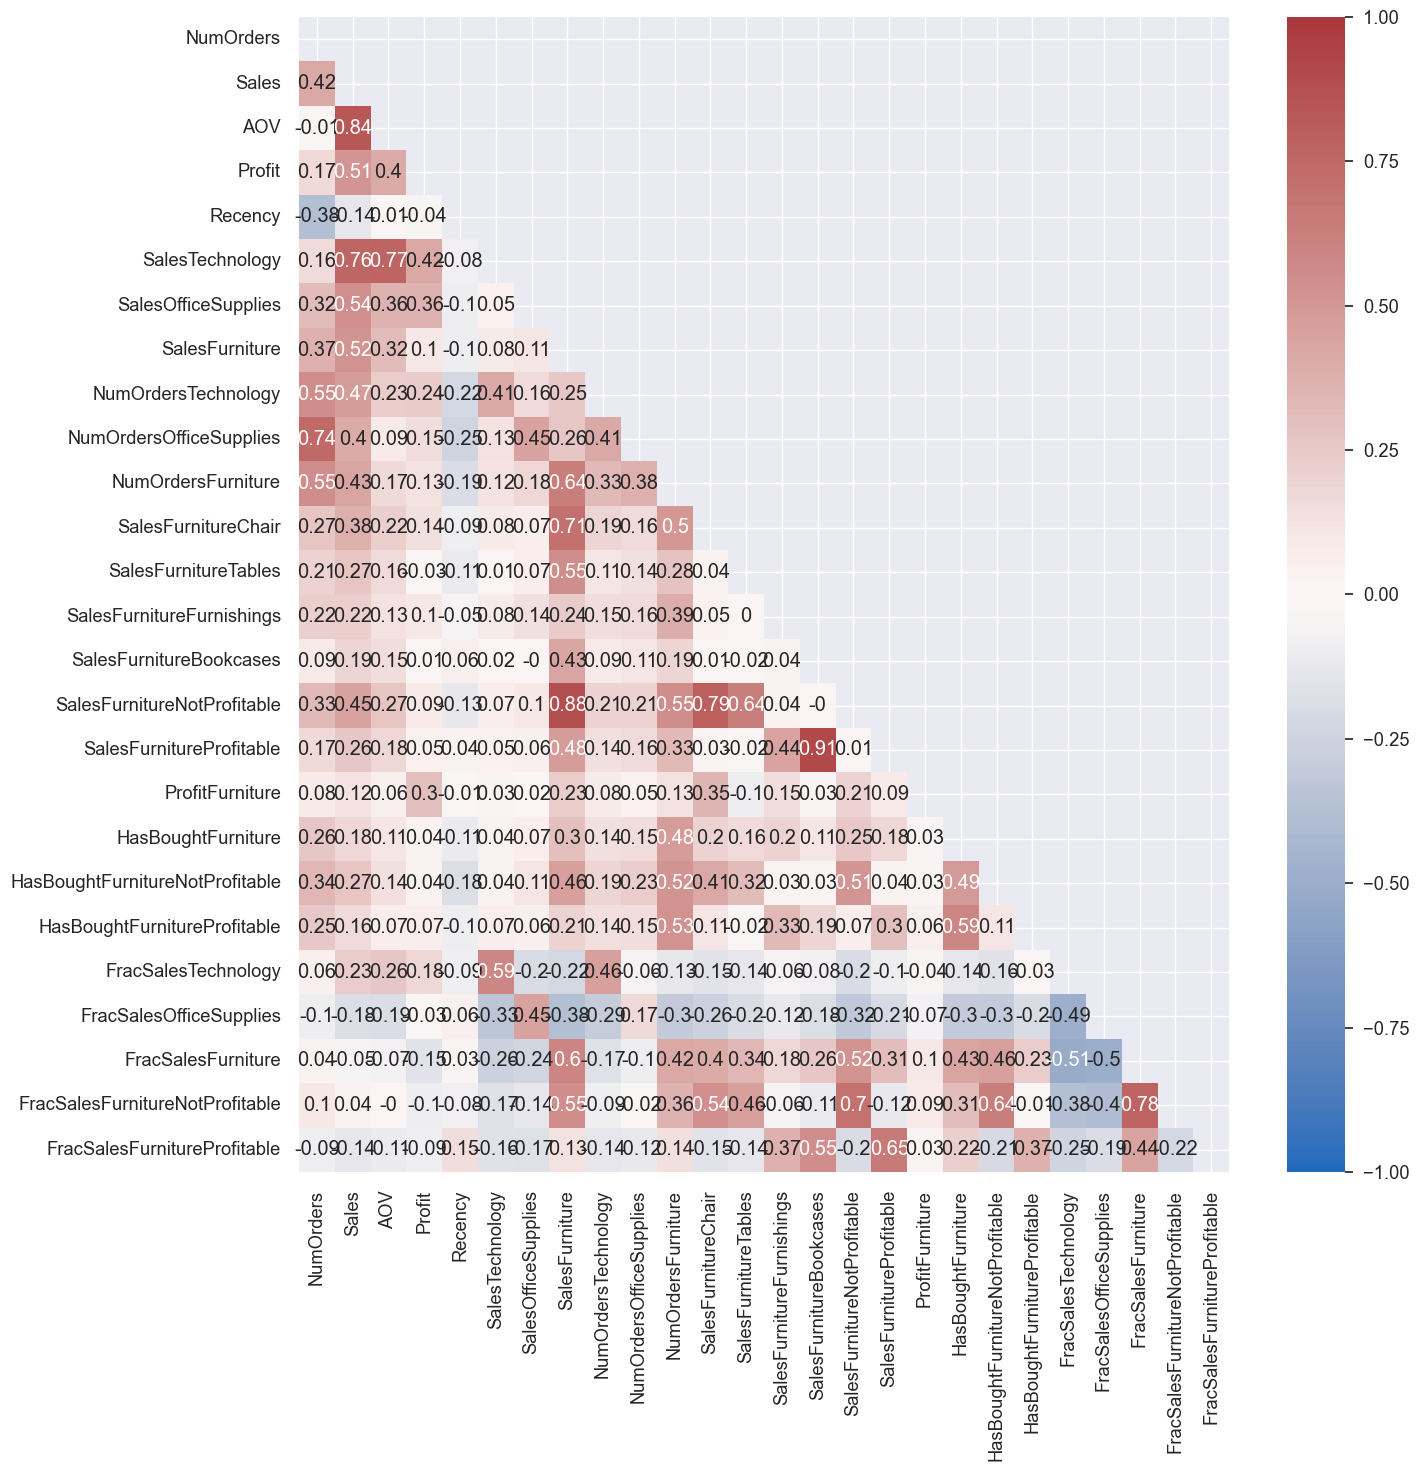

In [93]:
plt.subplots(figsize=(15,15))
matrix = df.corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

# Machine Learning

In [539]:
# re-run the notebook
if hasattr(df, 'Cluster'):
    df = df.drop(columns='Cluster')

## Feature Selection

In [540]:
df.columns

Index(['Segment', 'NumOrders', 'Sales', 'AOV', 'Profit', 'Recency',
       'SalesTechnology', 'SalesOfficeSupplies', 'SalesFurniture',
       'NumOrdersTechnology', 'NumOrdersOfficeSupplies', 'NumOrdersFurniture',
       'SalesFurnitureChair', 'SalesFurnitureTables',
       'SalesFurnitureFurnishings', 'SalesFurnitureBookcases',
       'SalesFurnitureNotProfitable', 'SalesFurnitureProfitable',
       'ProfitFurniture', 'HasBoughtFurniture',
       'HasBoughtFurnitureNotProfitable', 'HasBoughtFurnitureProfitable',
       'FracSalesTechnology', 'FracSalesOfficeSupplies', 'FracSalesFurniture',
       'FracSalesFurnitureNotProfitable', 'FracSalesFurnitureProfitable'],
      dtype='object')

In [541]:
# Select features for clustering
numeric_features = [
    # 'NumOrders', 'Sales', 'AOV', 'Profit', 'Recency', 
    'SalesTechnology', 'SalesOfficeSupplies', 'SalesFurniture',
    # 'NumOrdersTechnology', 'NumOrdersOfficeSupplies', 
    # 'NumOrdersFurniture',
    # 'SalesFurnitureChair', 'SalesFurnitureTables', 'SalesFurnitureFurnishings', 'SalesFurnitureBookcases',
    # 'SalesFurnitureNotProfitable', 'SalesFurnitureProfitable',
    'ProfitFurniture',
    # 'HasBoughtFurniture',
    'HasBoughtFurnitureNotProfitable', 'HasBoughtFurnitureProfitable',
    # 'FracSalesTechnology', 'FracSalesOfficeSupplies', 'FracSalesFurniture',
    # 'FracSalesFurnitureNotProfitable', 'FracSalesFurnitureProfitable'
    ]

categorical_features = [
    # 'Segment' # not helpful in distinguishing groups according to furniture
]

features = numeric_features + categorical_features
X = df[features]
X.head()

,SalesTechnology,SalesOfficeSupplies,SalesFurniture,ProfitFurniture,HasBoughtFurnitureNotProfitable,HasBoughtFurnitureProfitable
CustomerID,,,,,,
AA-10315,473.696,5075.304,14.560,6.2608,0,1
AA-10375,766.930,261.060,28.400,11.0760,0,1
AA-10480,689.940,625.272,475.300,108.4104,1,1
AA-10645,354.682,981.540,3750.713,648.8834,1,1
AB-10015,221.980,273.504,390.672,60.1937,1,1


In [542]:
df.HasBoughtFurniture.mean()

np.float64(0.8915510718789408)

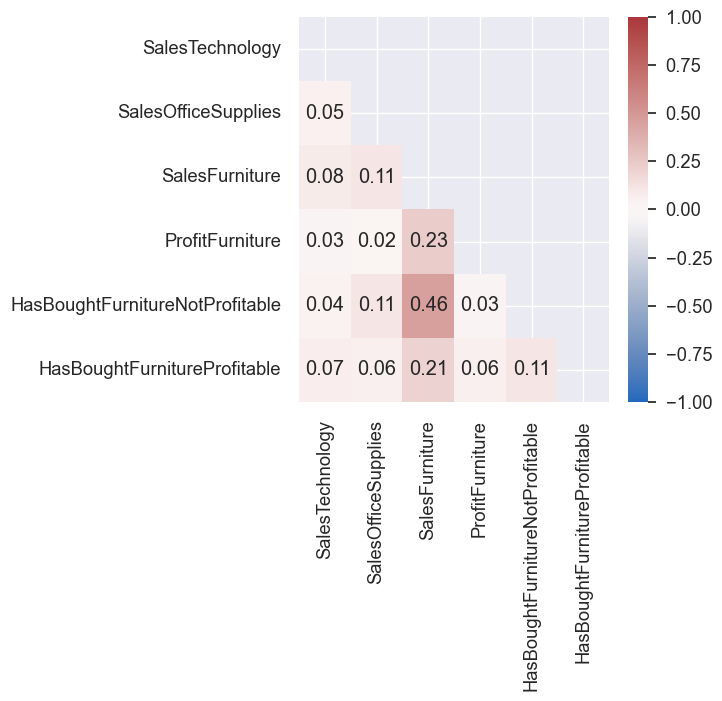

In [543]:
plt.subplots(figsize=(5,5))
matrix = X.corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

In [544]:
# check variance / std of selected features
X.describe()

,SalesTechnology,SalesOfficeSupplies,SalesFurniture,ProfitFurniture,HasBoughtFurnitureNotProfitable,HasBoughtFurnitureProfitable
count,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000
mean,1054.418705,906.742789,935.687005,23.267683,0.664565,0.744010
std,1862.697540,1208.277422,1074.064212,234.108108,0.472440,0.436692
min,0.000000,0.000000,0.000000,-1862.312400,0.000000,0.000000
25%,102.104000,216.622000,160.185000,-26.179200,0.000000,0.000000
50%,453.576000,549.394000,626.100000,10.393600,1.000000,1.000000
75%,1297.572000,1106.421000,1347.200000,89.305200,1.000000,1.000000
max,23481.508000,12081.258000,8332.090000,1146.487800,1.000000,1.000000


## Pipelining

In [545]:
# Gower distance transformation
from sklearn.base import BaseEstimator, TransformerMixin

class GowerDistanceTransformer(BaseEstimator, TransformerMixin):
    """
    A scikit-learn compatible transformer to compute the Gower distance matrix.
    """
    def __init__(self, cat_feature_mask, weight=None):
        self.X_train_ = None                        # To store training data for distance calculation
        self.cat_feature_mask_ = cat_feature_mask   # bool mask to identify categorical features
        self.weight_ = weight                       # gower_matrix weight

    def fit(self, X, y=None):
        """
        Stores the training data to calculate distances against in the transform step.
        """
        self.X_train_ = X.copy()
        return self

    def transform(self, X):
        """
        Computes the Gower distance matrix between X and the stored training data (X_train_).
        """
        if self.X_train_ is None:
            raise RuntimeError("GowerDistanceTransformer has not been fitted yet.")

        # Calculate Gower distance.
        # It's important that your categorical columns are 'object' dtype
        # and numerical columns are numerical dtypes (int, float).
        distance_matrix = gower.gower_matrix(X, self.X_train_, weight=self.weight_, cat_features=self.cat_feature_mask_)
        return distance_matrix
    

In [546]:
# build preprocessor for ML pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

scaler = StandardScaler()

features_log_and_scale = []
# if 'Sales' in features: features_log_and_scale.append('Sales')
# if 'SalesTechnology' in features: features_log_and_scale.append('SalesTechnology')
# if 'SalesOfficeSupplies' in features: features_log_and_scale.append('SalesOfficeSupplies')
# if 'SalesFurniture' in features: features_log_and_scale.append('SalesFurniture')

features_scale = [feat for feat in numeric_features if feat not in features_log_and_scale]

log_and_scale_pipeline = Pipeline([
    ('log1p', FunctionTransformer(np.log1p, validate=False)), # Apply log(1+x)
    ('scaler', scaler) # Then scale the log-transformed values
])

preprocessor = ColumnTransformer(
    transformers=[
        ('log_and_scale', log_and_scale_pipeline, features_log_and_scale),
        ('scale', scaler, features_scale),
        ('categorical', 'passthrough', categorical_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [547]:
# pd.DataFrame(preprocessor.fit_transform(X), index=X.index, columns=X.columns)
cat_feat_mask = [feat in categorical_features for feat in features]

In [605]:
len(categorical_features)>0

False

In [606]:
steps = []
if len(categorical_features) == 0:
    steps = [
        ('preprocessor', preprocessor),
        ('clustering', KMeans(random_state=42, n_init='auto'))
    ]
else:
    steps = [
        ('preprocessor',    preprocessor),
        ('gowerdistance',   GowerDistanceTransformer(cat_feature_mask=cat_feat_mask)),
        ('clustering',      KMeans(random_state=42, n_init='auto'))
    ]
kmeans_pipe = Pipeline(steps=steps)

In [607]:
kmeans_pipe

,steps,"[('preprocessor', ...), ('clustering', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log_and_scale', ...), ('scale', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


## Determine Number of Clusters

In [608]:
# Determine Optimal Number of Clusters (Elbow Method) 
km = []
inertia = []
silhouette = []
dbi = []
chs = []
max_num_clusters = 50 # len(df)-1
range_clusters = range(2, max_num_clusters) # K can't be more than number of samples
X_scaled = kmeans_pipe[:-1].fit_transform(X)
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    km.append(kmeans)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))
    dbi.append(davies_bouldin_score(X_scaled, kmeans.labels_))
    chs.append(calinski_harabasz_score(X_scaled, kmeans.labels_))

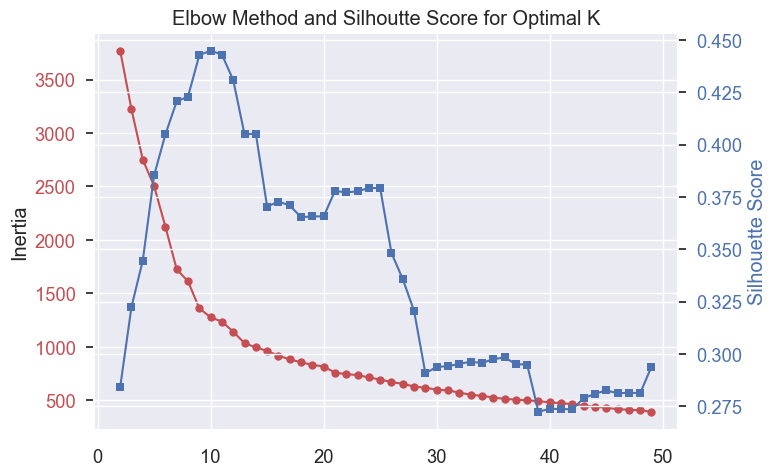

In [609]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot temperature on the left y-axis
ax1.plot(range_clusters, inertia, 'r-o')
ax1.set_ylabel('Inertia')
ax1.tick_params(axis='y', labelcolor='r')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(range_clusters, silhouette, 'b-s')#, label='Electricity Consumption (kWh)')
ax2.set_ylabel('Silhouette Score', color='b')
ax2.tick_params(axis='y', labelcolor='b')


plt.title('Elbow Method and Silhoutte Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.grid(True)
plt.tight_layout()
plt.show()

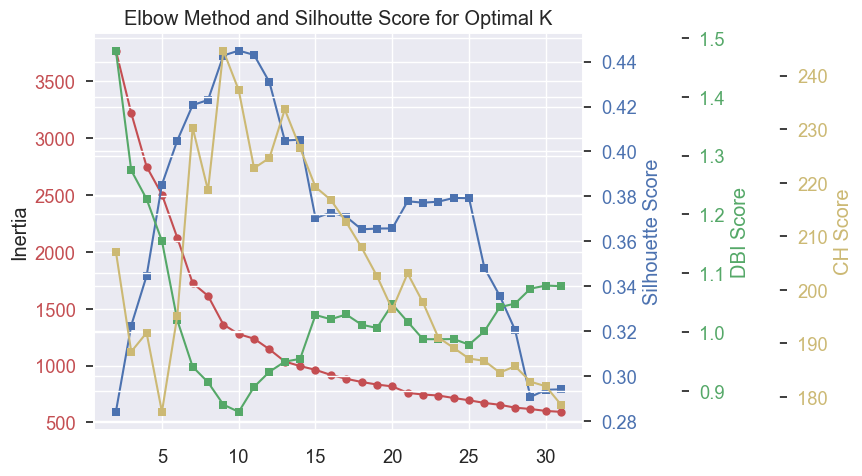

In [610]:
fig, ax1 = plt.subplots(figsize=(10, 5))

n_clusters = 30

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()

ax1.spines.left.set_position(("axes", 0.))
ax2.spines.left.set_position(("axes", 0.))
ax3.spines.right.set_position(("axes", 1.2))
ax4.spines.right.set_position(("axes", 1.4))

ax3.spines.right.set_visible(True)
ax4.spines.right.set_visible(True)

# Plot temperature on the left y-axis
ax1.plot(range_clusters[:n_clusters], inertia[:n_clusters], 'r-o')
ax1.set_ylabel('Inertia')
ax1.tick_params(axis='y', labelcolor='r')

# Create a second y-axis for silhouette score
ax2.plot(range_clusters[:n_clusters], silhouette[:n_clusters], 'b-s')#, label='Electricity Consumption (kWh)')
ax2.set_ylabel('Silhouette Score', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Create a third y-axis for DBI Score
ax3.plot(range_clusters[:n_clusters], dbi[:n_clusters], 'g-s')#, label='Electricity Consumption (kWh)')
ax3.set_ylabel('DBI Score', color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Create a third y-axis for CHI Score
ax4.plot(range_clusters[:n_clusters], chs[:n_clusters], 'y-s')#, label='Electricity Consumption (kWh)')
ax4.set_ylabel('CH Score', color='y')
ax4.tick_params(axis='y', labelcolor='y')

plt.title('Elbow Method and Silhoutte Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.grid(visible=False)
plt.tight_layout()
plt.show()

How to find the optimal number of clusters: 
* maximize Silhoutte, CH-Score
* minimize DBI

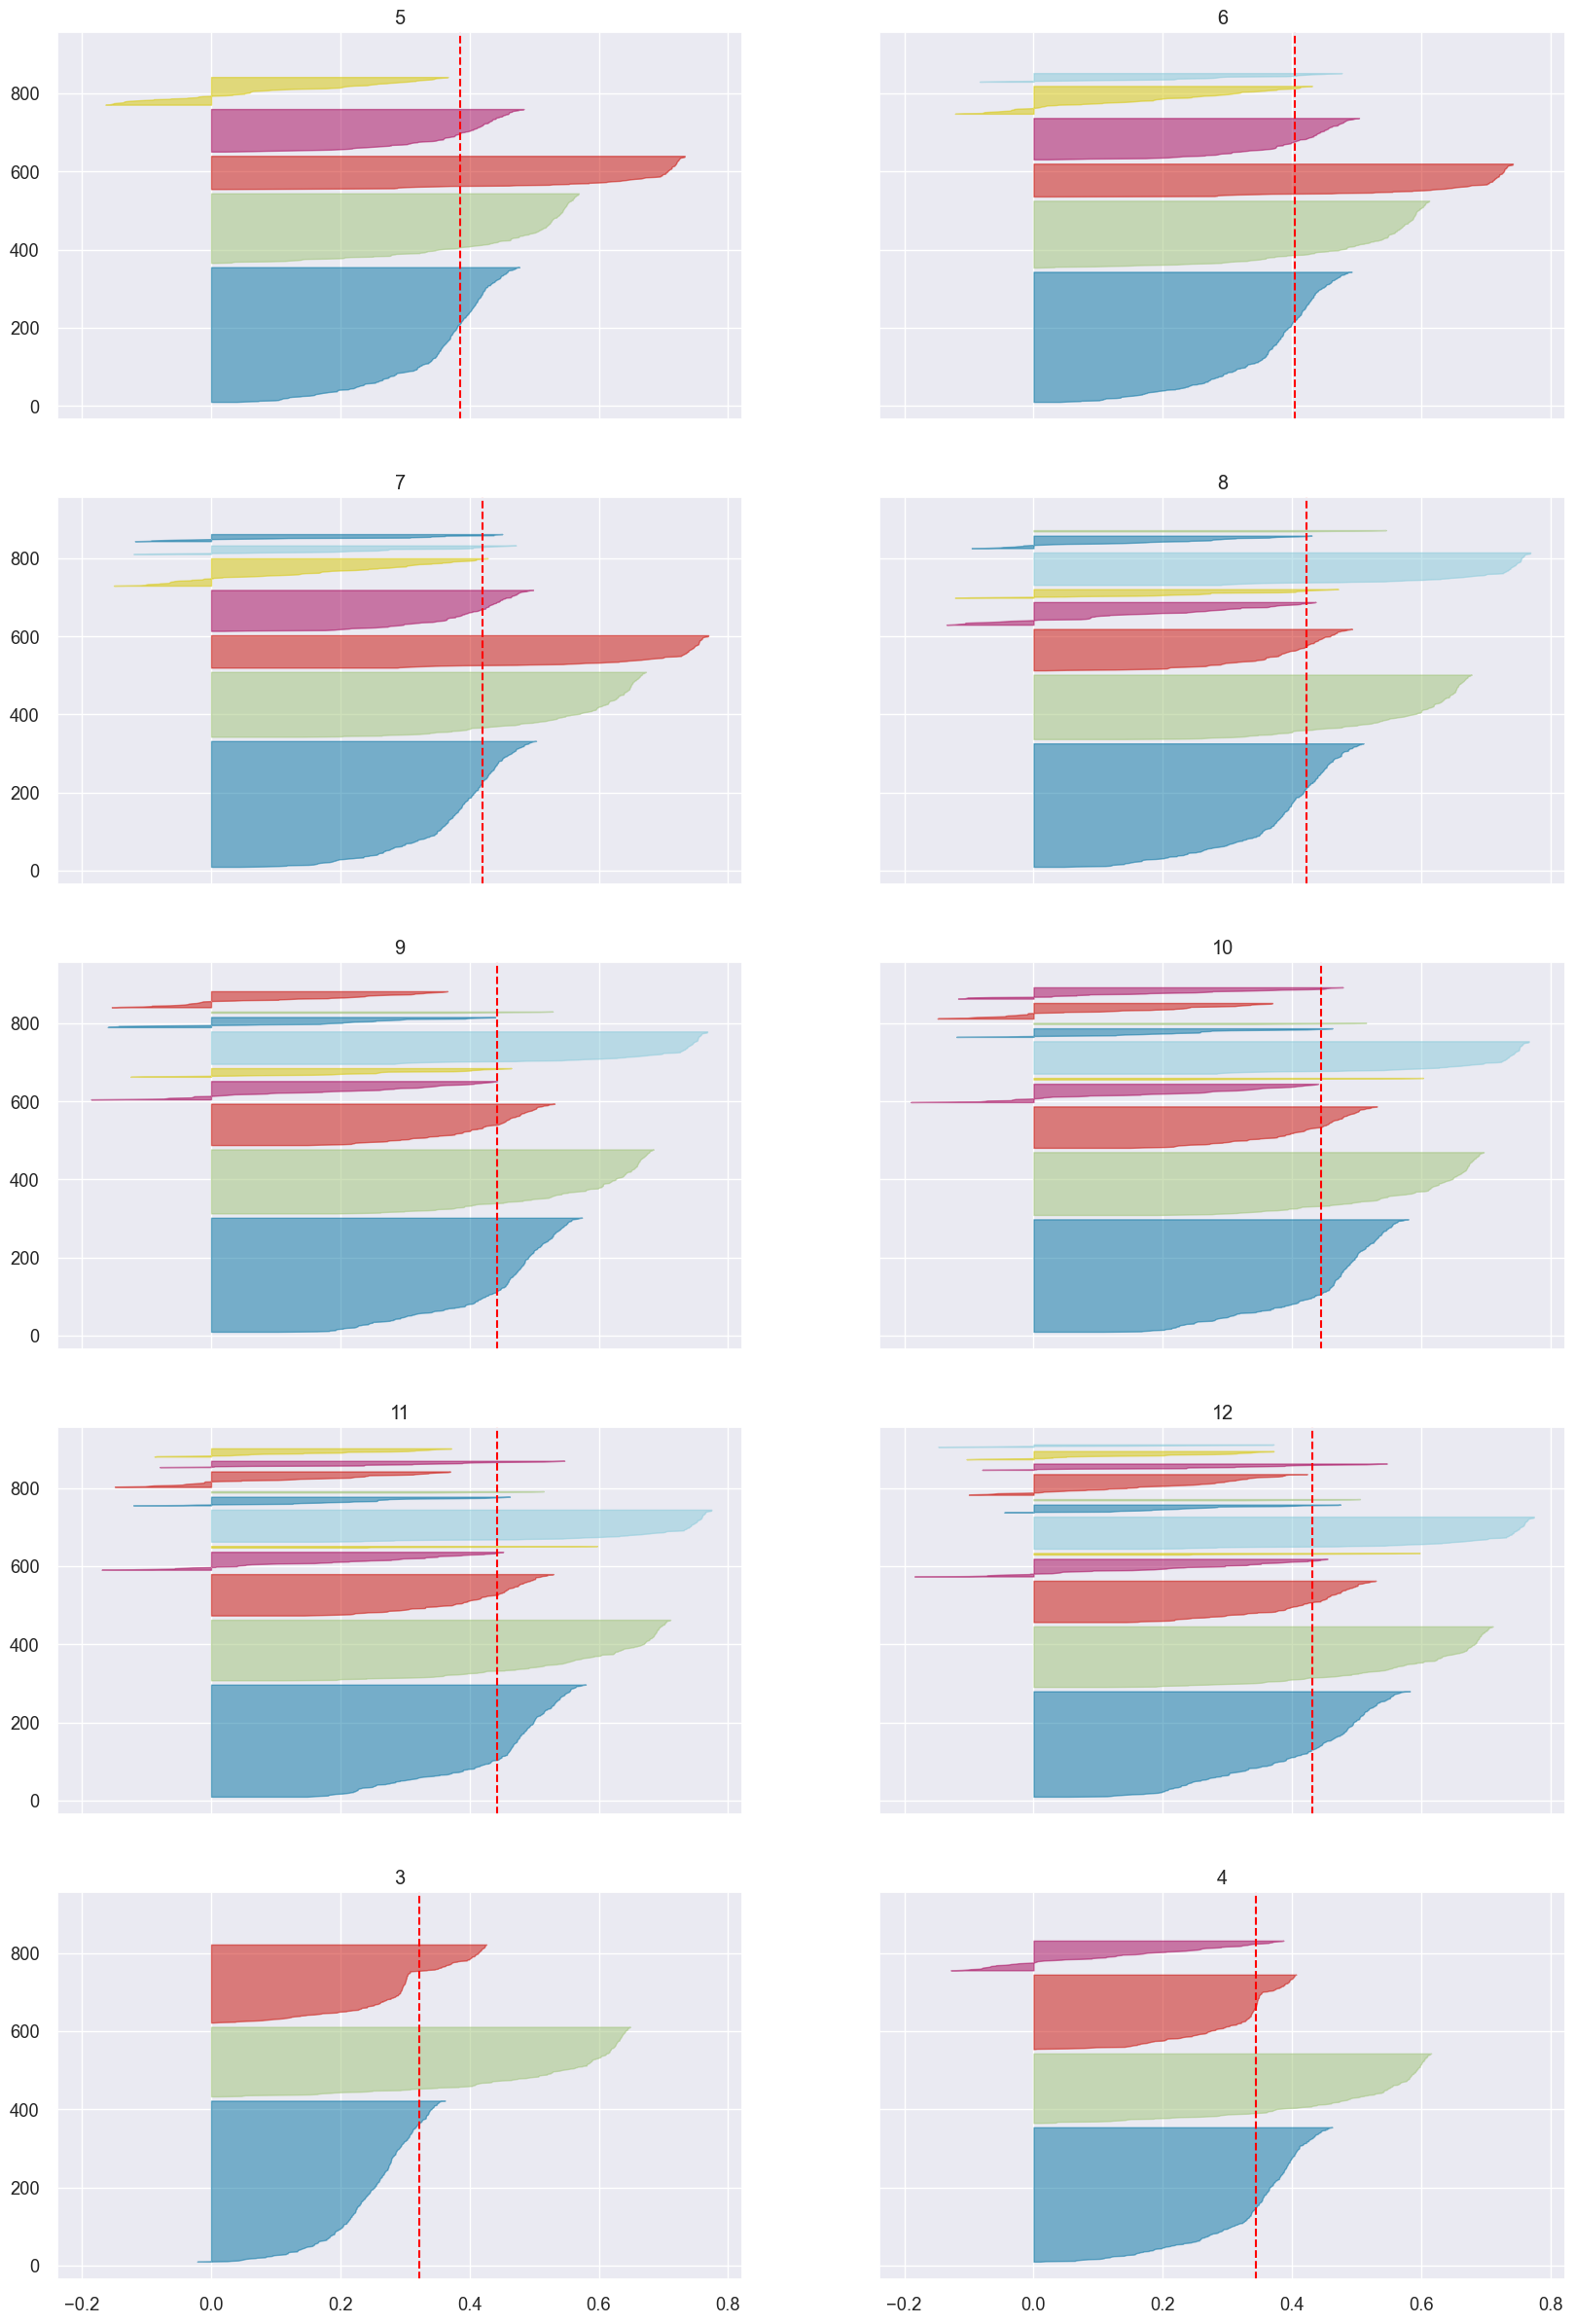

In [611]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(5, 2, figsize=(20,30), sharex=True, sharey=True)

for i, k in enumerate(km[1:11]):
    '''
    Create KMeans instance for different number of clusters
    '''
    # km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(k, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_scaled)
    ax[q-1][mod].set_title(f'{k.n_clusters}')

In [612]:
inertia_diff = pd.Series(inertia[:-1]) - pd.Series(inertia[1:])
inertia_diff.index = (inertia_diff.index+1)
inertia_diff

1     549.467399
2     470.805834
3     245.634916
4     380.520585
5     398.876581
6     111.887741
7     252.550992
8      84.255984
9      40.096686
10     93.694562
11    107.239497
12     40.028266
13     33.193648
14     44.668366
15     33.948995
16     28.028351
17     22.616663
18     16.364345
19     56.720836
20     14.585635
21      8.864274
22     21.870740
23     19.971230
24     23.334047
25     16.390779
26     25.203743
27     11.968772
28     16.850972
29      8.341659
30     18.950931
31     21.523166
32      9.045462
33     16.443526
34     11.873707
35      7.774992
36      7.202104
37      6.331334
38     11.410509
39      8.088046
40      8.538965
41     15.962842
42      8.243382
43      9.122347
44     13.789935
45      6.008951
46      4.965771
47     14.634362
dtype: float64

## Perform Clustering and Analyse

In [628]:
# select optimal number of clusters from the above plot
optimal_k = 9
print('Inertia Diff', inertia_diff[optimal_k])
print('Silhouette', silhouette[optimal_k-2])
print('DBI', dbi[optimal_k-2])
print('CHS', chs[optimal_k-2])

Inertia Diff 40.09668587196097
Silhouette 0.4426823610383809
DBI 0.8768025692258863
CHS 244.65234826968904


In [630]:
# Perform K-Means Clustering
kmeans_pipe.named_steps['clustering'].set_params(n_clusters=optimal_k)
df['Cluster'] = kmeans_pipe.fit_predict(X)

print(f"\nCustomer Data with {optimal_k} Clusters:")
df.head()


Customer Data with 9 Clusters:


,Segment,NumOrders,Sales,AOV,Profit,Recency,SalesTechnology,SalesOfficeSupplies,SalesFurniture,NumOrdersTechnology,...,ProfitFurniture,HasBoughtFurniture,HasBoughtFurnitureNotProfitable,HasBoughtFurnitureProfitable,FracSalesTechnology,FracSalesOfficeSupplies,FracSalesFurniture,FracSalesFurnitureNotProfitable,FracSalesFurnitureProfitable,Cluster
CustomerID,,,,,,,,,,,,,,,,,,,,,
AA-10315,Consumer,5,5563.560,1112.712000,-362.8825,184.0,473.696,5075.304,14.560,2,...,6.2608,1,0,1,0.085143,0.912240,0.002617,0.000000,0.002617,4
AA-10375,Consumer,9,1056.390,117.376667,277.3824,19.0,766.930,261.060,28.400,3,...,11.0760,1,0,1,0.725991,0.247125,0.026884,0.000000,0.026884,1
AA-10480,Consumer,4,1790.512,447.628000,435.8274,259.0,689.940,625.272,475.300,2,...,108.4104,1,1,1,0.385331,0.349214,0.265455,0.250118,0.015336,0
AA-10645,Consumer,6,5086.935,847.822500,857.8033,55.0,354.682,981.540,3750.713,2,...,648.8834,1,1,1,0.069724,0.192953,0.737323,0.461553,0.275770,3
AB-10015,Consumer,3,886.156,295.385333,129.3465,415.0,221.980,273.504,390.672,1,...,60.1937,1,1,1,0.250498,0.308641,0.440861,0.054970,0.385891,0


In [643]:
kmeans_pipe

,steps,"[('preprocessor', ...), ('clustering', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log_and_scale', ...), ('scale', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [644]:
# cluster profiling
cluster_profiles = df.groupby('Cluster').agg({
    'Segment' : (',').join,
    'NumOrders':'sum',
    'Sales':'sum', 
    'AOV':'mean', 
    'Profit':'sum',
    'Recency':'mean',
    'SalesTechnology':'sum',
    'SalesOfficeSupplies':'sum', 'SalesFurniture':'sum', 'NumOrdersTechnology':'sum',
    'NumOrdersOfficeSupplies':'sum', 'NumOrdersFurniture':'sum', 'SalesFurnitureChair':'sum',
    'ProfitFurniture':'sum', 
    'HasBoughtFurniture':'mean',
    'HasBoughtFurnitureNotProfitable':'mean', 'HasBoughtFurnitureProfitable':'mean'
})

print("\nCluster Profiles (Average Feature Values within each Cluster):")
cluster_profiles[[
    'Sales', 'Profit', 'AOV', #'ProfitFurniture',
#     'SalesTechnology','SalesOfficeSupplies', 'SalesFurniture'
    ] + features].round(2).sort_values('SalesFurniture', ascending=False)


Cluster Profiles (Average Feature Values within each Cluster):


,Sales,Profit,AOV,SalesTechnology,SalesOfficeSupplies,SalesFurniture,ProfitFurniture,HasBoughtFurnitureNotProfitable,HasBoughtFurnitureProfitable
Cluster,,,,,,,,,
0,752197.29,82361.86,391.42,243560.73,227004.24,281632.33,11317.52,1.00,1.00
3,291170.53,42913.91,805.78,64427.63,56457.03,170285.87,24681.74,0.98,0.90
8,181533.35,-11893.29,559.70,39428.01,43604.64,98500.69,-21569.94,0.98,0.95
2,244806.27,28772.79,398.35,78302.08,79546.64,86957.55,259.84,1.00,0.00
1,248166.87,37292.80,293.24,101397.01,93917.28,52852.58,3012.11,0.00,1.00
6,223280.48,37277.81,1301.63,170548.57,24474.75,28257.15,-11.70,0.89,0.96
4,176317.46,39051.79,1020.49,13486.69,140197.11,22633.66,744.91,0.65,0.87
7,73808.23,18680.47,3746.88,69454.83,3473.43,879.96,16.80,0.00,0.75
5,105920.38,11938.88,278.73,55548.48,50371.90,0.00,0.00,0.00,0.00


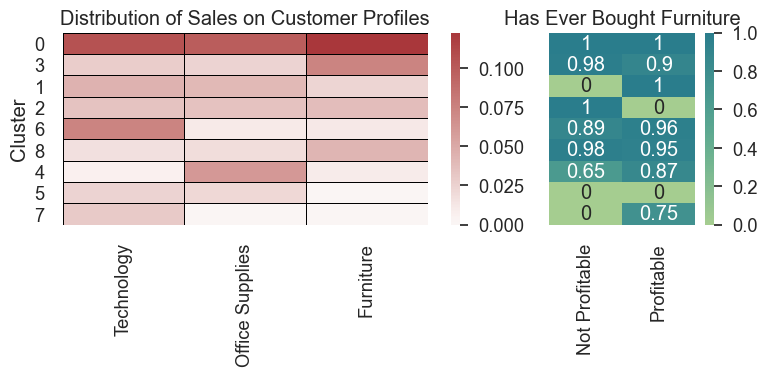

In [645]:
sns.set_theme(font_scale=1.2)

matrix = cluster_profiles[[
    'Sales', 'SalesTechnology', 'SalesOfficeSupplies', 'SalesFurniture', 'ProfitFurniture', 
    'HasBoughtFurniture', 'HasBoughtFurnitureNotProfitable', 'HasBoughtFurnitureProfitable'
                           ]] .sort_values('Sales', ascending=False)
matrix['SalesTechnology'] /= cluster_profiles['Sales'].sum()
matrix['SalesOfficeSupplies'] /= cluster_profiles['Sales'].sum() # cluster_profiles['SalesOfficeSupplies'].sum()
matrix['SalesFurniture'] /= cluster_profiles['Sales'].sum() # cluster_profiles['SalesFurniture'].sum()
matrix['ProfitFurniture'] /= cluster_profiles['ProfitFurniture'].sum()

categories = ['Technology', 'Office Supplies', 'Furniture']

# mask = np.triu(np.ones_like(matrix, dtype=bool))
fig, ax = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [2.5, 1]}, figsize=(8,4))
sns.heatmap(matrix[['SalesTechnology', 'SalesOfficeSupplies', 'SalesFurniture']], center=0, cmap='vlag', ax=ax[0], linewidths=.5, linecolor='black', yticklabels=[], xticklabels=categories)#, mask=mask) vmax=1, vmin=-0.05, 
# sns.heatmap(matrix[['ProfitFurniture']], center=0, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax[1])#, mask=mask) vmax=1, vmin=-0.05, 
sns.heatmap(matrix[['HasBoughtFurnitureNotProfitable', 'HasBoughtFurnitureProfitable']], center=0.9, annot=True, vmax=1, vmin=0, cmap='crest', ax=ax[1], xticklabels=['Not Profitable', 'Profitable'])#, mask=mask) vmax=1, vmin=-0.05, 

ax[1].set_ylabel('')

ax[0].set_title('Distribution of Sales on Customer Profiles')
ax[1].set_title('Has Ever Bought Furniture')

plt.tight_layout()
plt.show()

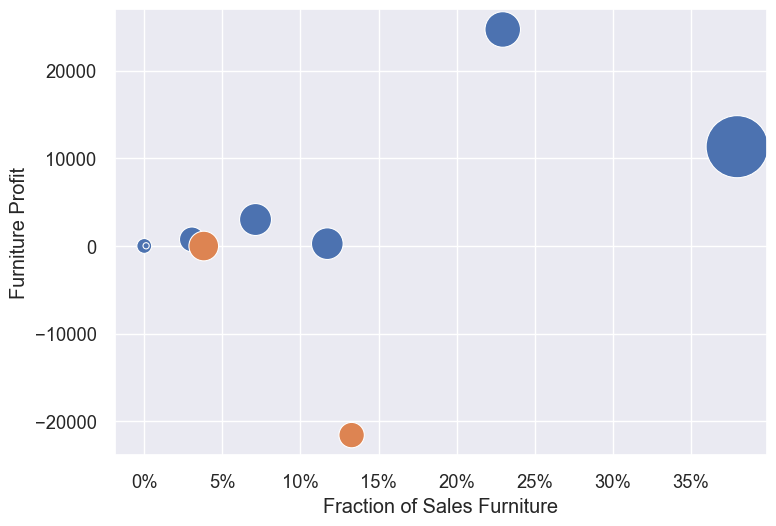

In [647]:
cluster_profiles_plot = cluster_profiles.copy()
cluster_profiles_plot.SalesFurniture = cluster_profiles_plot.SalesFurniture / cluster_profiles_plot.SalesFurniture.sum()
# cluster_profiles_plot.ProfitFurniture = cluster_profiles_plot.ProfitFurniture / cluster_profiles_plot.ProfitFurniture.sum()

fig, ax = plt.subplots()

sns.scatterplot(
    data=cluster_profiles_plot.reset_index(),
    x="SalesFurniture",
    y="ProfitFurniture",
    size="Sales",
    hue=cluster_profiles_plot.ProfitFurniture<0,
    legend=False,
    sizes=(20, 2000)
)

# Define a function to format the labels
def percent_formatter_func(x, pos):
    """
    Formats a number as a percentage.
    x: the tick value
    pos: the tick position (unused here, but required by FuncFormatter signature)
    """
    return f'{x:.0%}' # Formats as percentage with 1 decimal place
import matplotlib.ticker as mtick # Import the ticker module
ax.xaxis.set_major_formatter(mtick.FuncFormatter(percent_formatter_func))
# ax.yaxis.set_major_formatter(mtick.FuncFormatter(percent_formatter_func))

ax.set_xlabel('Fraction of Sales Furniture')
ax.set_ylabel('Furniture Profit')
# plt.grid(False)
# sns.despine()
plt.tight_layout()

In [634]:
# Analyze 'Has_Purchased_LowProfitCatX' for each cluster
low_profit_presence = df.groupby('Cluster')[['Sales', 'Profit', 'HasBoughtFurniture']].agg({
    'Sales'                 : ('mean', 'sum'), 
    'Profit'                : ('mean', 'sum'), 
    'HasBoughtFurniture'    : 'mean'
    })

print("\nAverage 'HasBoughtFurniture' per Cluster (Proportion of Cluster buying it):")
low_profit_presence.sort_values(('Profit', 'sum'), ascending=False).round(2)


Average 'HasBoughtFurniture' per Cluster (Proportion of Cluster buying it):


Sales              Profit           HasBoughtFurniture
             mean        sum     mean       sum               mean
Cluster                                                           
0         2567.23  752197.29   281.10  82361.86               1.00
3         6066.05  291170.53   894.04  42913.91               1.00
4         7665.98  176317.46  1697.90  39051.79               0.96
1         1504.04  248166.87   226.02  37292.80               1.00
6         8269.65  223280.48  1380.66  37277.81               1.00
2         2287.91  244806.27   268.90  28772.79               1.00
7        18452.06   73808.23  4670.12  18680.47               0.75
5         1260.96  105920.38   142.13  11938.88               0.00
8         4322.22  181533.35  -283.17 -11893.29               1.00

# What is the Customer Group with lowest Profit in Furniture doing? 

In [635]:
%store -r dashboard_data

In [636]:
def show_value_counts_pie(value_counts, ax):
    return ax.pie(value_counts.values, labels=value_counts.index);

In [637]:
dashboard_data.Category.value_counts()

Category
Office Supplies    6022
Furniture          2119
Technology         1845
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x24bdfbd0190>,
 [Text(-0.2523236758258577, 1.0706693059099657, 'Office Supplies'),
  Text(-0.3430924184511618, -1.0451256347450928, 'Furniture'),
  Text(0.938558003082995, -0.5736801154379164, 'Technology')])

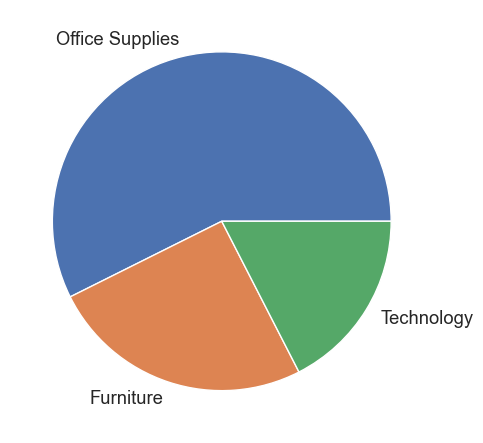

In [638]:
mask_cluster = dashboard_data.CustomerID.isin(df[df.Cluster == 0].index)
mask_cat_furniture = dashboard_data.Category == 'Furniture'

fig, ax = plt.subplots()

data = dashboard_data[mask_cluster].Category.value_counts()
show_value_counts_pie(data, ax)

In [639]:
dashboard_data[mask_cluster & mask_cat_furniture].Discount.value_counts()

Discount
0.00    393
0.20    325
0.30    125
0.60     72
0.10     30
0.40     28
0.50     24
0.15     23
0.32     12
0.70      6
0.45      4
Name: count, dtype: int64

<Axes: >

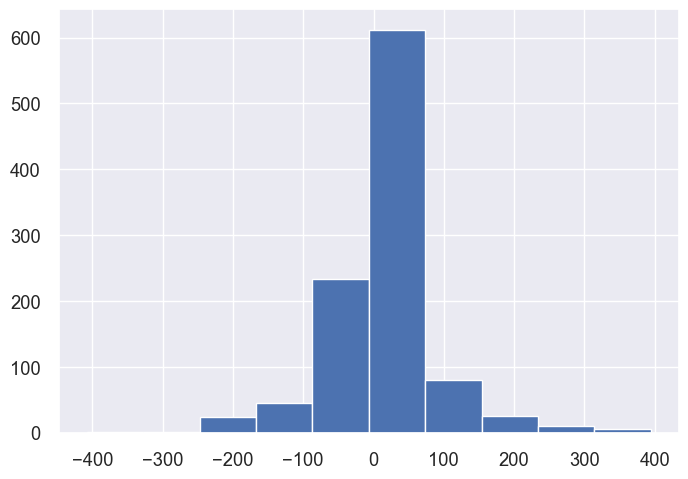

In [640]:
dashboard_data[mask_cluster & mask_cat_furniture].Profit.hist()

In [641]:
dashboard_data[mask_cluster & mask_cat_furniture & (dashboard_data.Profit<0)].Discount.value_counts()

Discount
0.30    118
0.20     85
0.60     72
0.40     28
0.50     24
0.32     12
0.15      7
0.70      6
0.45      4
0.10      3
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x24be672b890>,
 [Text(1.0149170066631674, 0.4241974417483871, 'SAFCO Arco Folding Chair'),
  Text(0.4332006001984219, 1.011106937958457, 'Global Leather Executive Chair'),
  Text(-0.36233712309450133, 1.038610518542731, 'Global Commerce Series High-Back Swivel/Tilt Chairs'),
  Text(-0.9589204364590762, 0.5389541692399595, 'Office Star - Professional Matrix Back Chair with 2-to-1 Synchro Tilt and Mesh Fabric Seat'),
  Text(-1.0888394568710764, -0.15629663195571245, 'Global Ergonomic Managers Chair'),
  Text(-0.8211492787178706, -0.7319247653011346, 'Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back'),
  Text(-0.30226399303118384, -1.0576561248897698, 'Global Leather Highback Executive Chair with Pneumatic Height Adjustment, Black'),
  Text(0.29278930806018727, -1.0603180754309705, 'Chromcraft Rectangular Conference Tables'),
  Text(0.7950133482481941, -0.7602327118107952, 'HON 5400 Series Task Chairs for Big and Tall'),
  Text(1.0663777516919444

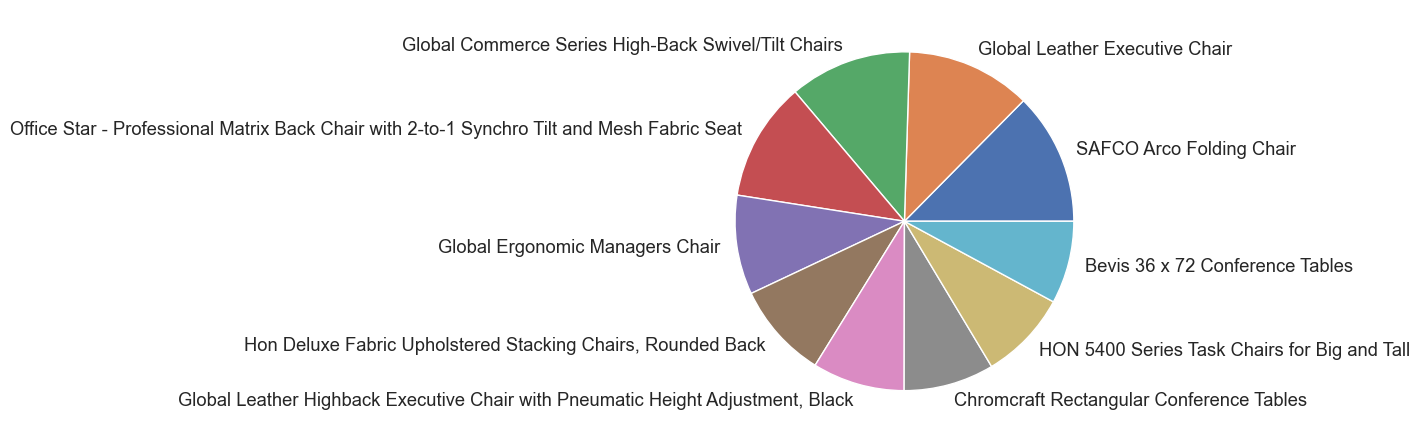

In [642]:
data = dashboard_data[mask_cluster & mask_cat_furniture].groupby('ProductName').Sales.sum()#value_counts()


fig, ax = plt.subplots()

show_value_counts_pie(data.sort_values(ascending=False).head(10), ax)